In [4]:
import numpy as np
import h5py

f = h5py.File("/oak/stanford/groups/akundaje/avsec/basepair/data/"
              +"processed/comparison/output/nexus,peaks,OSNK,0,10"
              +",1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE"
              +",FALSE,1/deeplift.imp_score.h5", "r")
#f = h5py.File("/users/avanti/deeplift.imp_score.h5","r")
nanog_mask = np.array(f['metadata']['interval_from_task'][:]=='Nanog')
nanog_profile_wn_hypimp = np.array(f["hyp_imp/Nanog/profile/wn"][:])[nanog_mask]
onehot_seq = np.array(f["inputs/seq"][:])[nanog_mask]
nanog_profile_wn_contribs = nanog_profile_wn_hypimp*onehot_seq

In [5]:
nanog_profile_wn_contribs.shape

(55233, 1000, 4)

In [7]:
from importlib import reload

%matplotlib inline
import h5py
import numpy as np
import modisco
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.phenograph
reload(modisco.cluster.phenograph)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.cluster
reload(modisco.cluster)
import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.affinitymat.transformers
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

%matplotlib inline

In [8]:
from collections import OrderedDict
import numpy as np
import scipy.stats


#def local_window_zscore(score_track, windowsize=400):
#    transformed_all_scores = []
#    for scores_row in score_track:

def per_sequence_zscore(score_track,
                        central=slice(0,1000)
                        #central=slice(400,600)
                       ):       
    transformed_all_scores = []                                                 
    for scores_row in score_track:                                              
        median = np.median(scores_row[central])                                          
        mad = scipy.stats.median_absolute_deviation(scores_row[central])                 
        transformed_all_scores.append((scores_row-median)/mad)           
    return transformed_all_scores


def per_sequence_zscore_log_percentile_transform(score_track, seed=1234):       
    score_track = per_sequence_zscore(score_track)
    transformed_all_scores = []
    for scores_row in score_track:                                              
        transformed_all_scores.append(                                          
         -np.log((1-(scipy.stats.norm.cdf(x=scores_row))) + 1e-16 ))           
    return transformed_all_scores 


transformed_perseq =\
    np.array(per_sequence_zscore_log_percentile_transform(
        #max_num_to_use_for_percentile=20000,
        score_track=[np.sum(s,axis=1) for s in nanog_profile_wn_contribs[:]]))

In [9]:
normal_perseq = np.array([np.sum(s,axis=1) for s in nanog_profile_wn_contribs[:]])

In [10]:
#let's do window sums for both, then find percentile ranking

def get_simple_window_sum_function(window_size):                                
    def window_sum_function(arrs):                                              
        to_return = []                                                          
        for arr in arrs:                                                        
            cumsum = np.cumsum(arr)                                             
            cumsum = np.array([0]+list(cumsum))                                 
            to_return.append(cumsum[window_size:]-cumsum[:-window_size])        
        return to_return                                                        
    return window_sum_function

window_size = 21
window_sum_function = get_simple_window_sum_function(window_size)
transformed_perseq_windowsum = np.array(window_sum_function(transformed_perseq))
normal_perseq_windowsum = np.array(window_sum_function(normal_perseq))

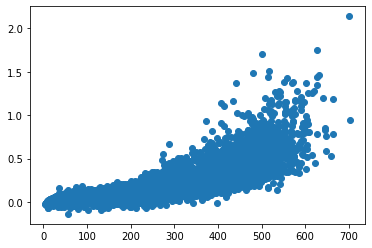

In [12]:
from matplotlib import pyplot as plt
plt.scatter(transformed_perseq_windowsum.ravel()[::1000], normal_perseq_windowsum.ravel()[::1000])
plt.show()

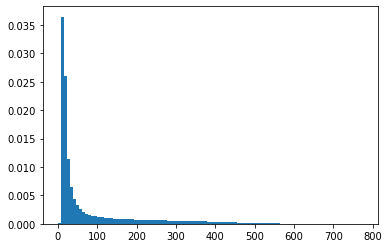

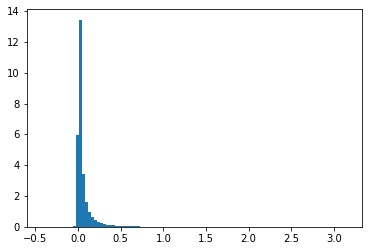

In [13]:
plt.hist(transformed_perseq_windowsum.ravel(), bins=100, density=True)
plt.show()
plt.hist(normal_perseq_windowsum.ravel(), bins=100, density=True)
plt.show()

In [14]:
def log_percentile(vals):
    raveled_vals = vals.ravel()
    subsample_size = 50000
    tosearch = sorted(np.random.RandomState(1234).choice(a=raveled_vals, replace=False, size=subsample_size))
    return -np.log((1-(np.searchsorted(a=tosearch, v=raveled_vals).reshape(vals.shape))/(subsample_size+1)))/np.log(10)

logperc_transformed_perseq_windowsum = log_percentile(transformed_perseq_windowsum)
logperc_normal_perseq_windowsum = log_percentile(normal_perseq_windowsum)

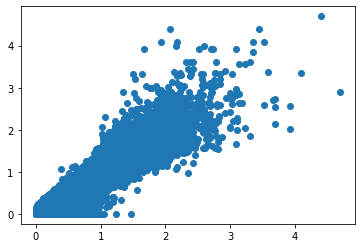

In [15]:
plt.scatter(logperc_transformed_perseq_windowsum.ravel()[::1000],
            logperc_normal_perseq_windowsum.ravel()[::1000])
plt.show()

In [22]:
transformed_rank_higher = np.nonzero((logperc_transformed_perseq_windowsum > 2)*(logperc_normal_perseq_windowsum < 1))
print(len(set(transformed_rank_higher[0])))

normal_rank_higher = np.nonzero((logperc_transformed_perseq_windowsum < 1)*(logperc_normal_perseq_windowsum > 2))
print(len(set(normal_rank_higher[0])))

#get a single example from each seq
rank_disagreements = normal_rank_higher 
seq_to_best_example = OrderedDict()
for seqidx, posidx in zip(*rank_disagreements):
    logperc_transformed_score = logperc_transformed_perseq_windowsum[seqidx, posidx]
    if seqidx not in seq_to_best_example:
        seq_to_best_example[seqidx] = (posidx, logperc_transformed_score)
    else:
        if seq_to_best_example[seqidx][-1] < logperc_transformed_score:
            seq_to_best_example[seqidx] = (posidx, logperc_transformed_score)

print(seq_to_best_example.keys())

54
33
odict_keys([169, 966, 1449, 1490, 1730, 1754, 1935, 2445, 3534, 4603, 5312, 5318, 6932, 7715, 10329, 11664, 13195, 13437, 14821, 14938, 16328, 17355, 17484, 18600, 19434, 23984, 30290, 32973, 33075, 39024, 40774, 50269, 52313])


169 465 0.9852362117297162 2.0132369515365376
slice(375, 575, None)


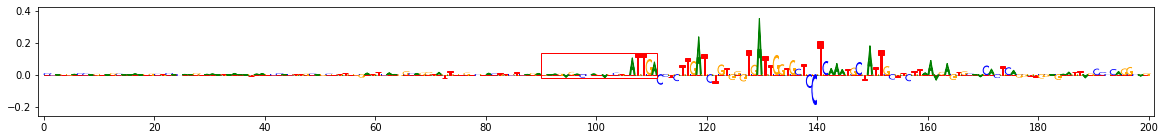

966 517 0.983393138245603 2.090452656561603
slice(427, 627, None)


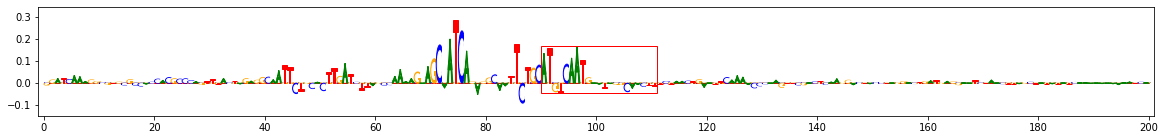

1449 507 0.9154324078684491 2.210427973638352
slice(417, 617, None)


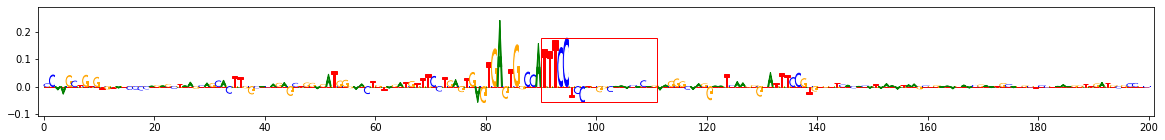

1490 480 0.9752767961475314 2.2020490420655814
slice(390, 590, None)


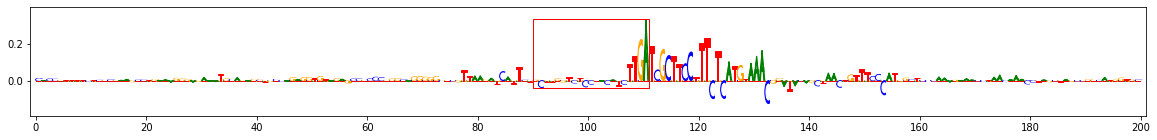

1730 505 0.958616000644555 2.4534660223246445
slice(415, 615, None)


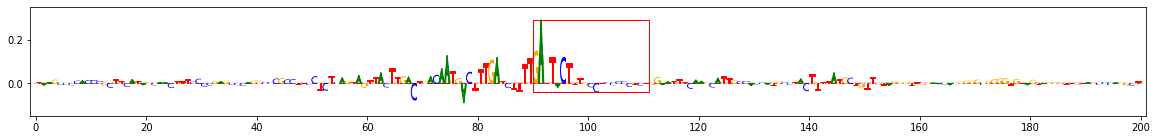

1754 497 0.9576694812392296 2.007897198015833
slice(407, 607, None)


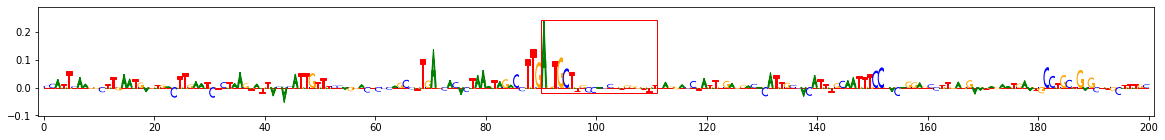

1935 510 0.9660223205631745 2.239586202379569
slice(420, 620, None)


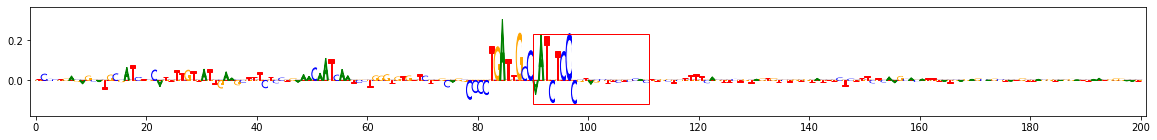

2445 506 0.9968067392810879 2.3080435830354182
slice(416, 616, None)


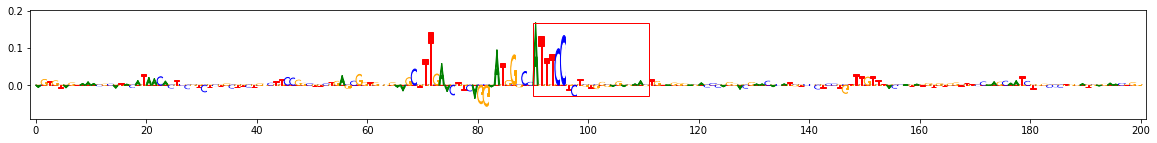

3534 507 0.9603566622208564 2.2612281273184083
slice(417, 617, None)


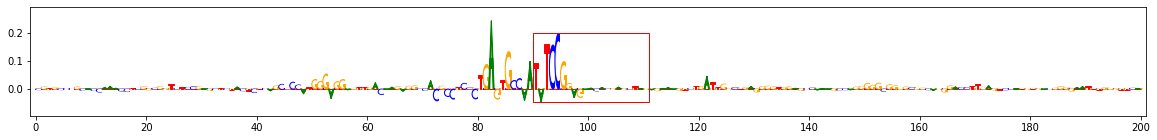

4603 500 0.9540601476974458 2.0132369515365376
slice(410, 610, None)


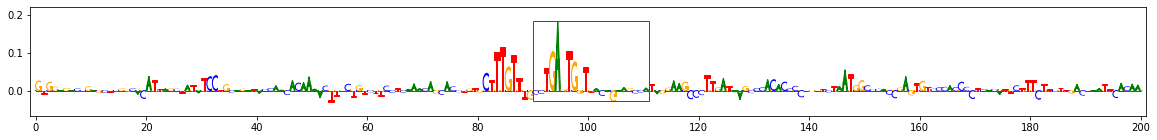

5312 506 0.9957733194433127 2.197919427921049
slice(416, 616, None)


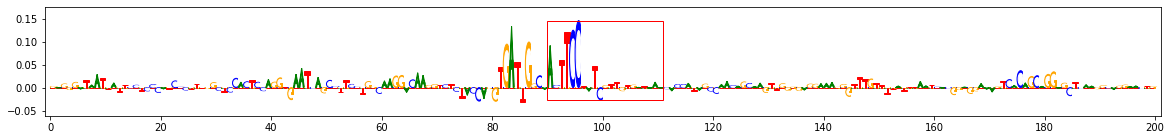

5318 522 0.9909829437158699 2.0123424208765037
slice(432, 632, None)


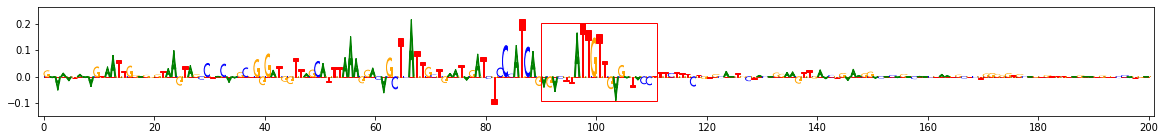

6932 503 0.9546074628069385 2.057504579634701
slice(413, 613, None)


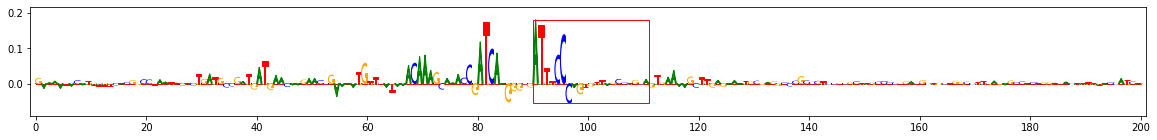

7715 503 0.9284948807076913 2.007013587371437
slice(413, 613, None)


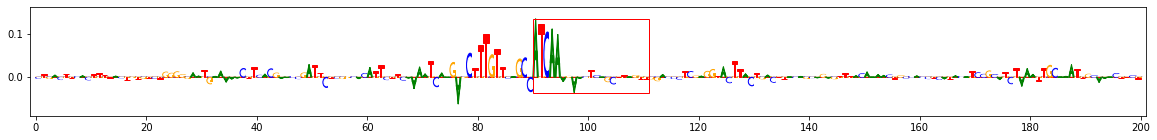

10329 483 0.9938850795909259 2.067534921125624
slice(393, 593, None)


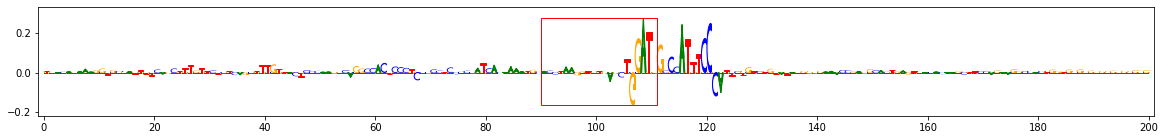

11664 503 0.9518000187786344 2.1700619898611433
slice(413, 613, None)


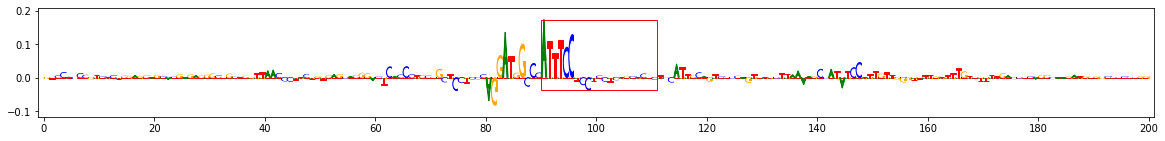

13195 357 0.9960314439572434 2.2020490420655814
slice(267, 467, None)


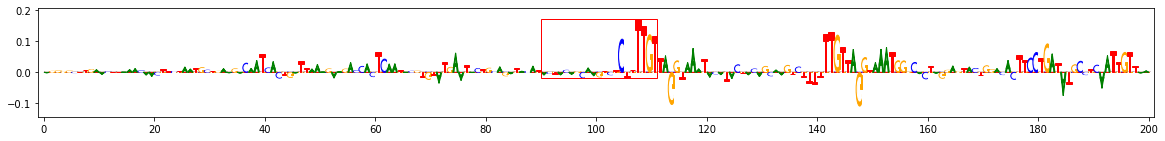

13437 506 0.9943992404424997 2.0381132121349284
slice(416, 616, None)


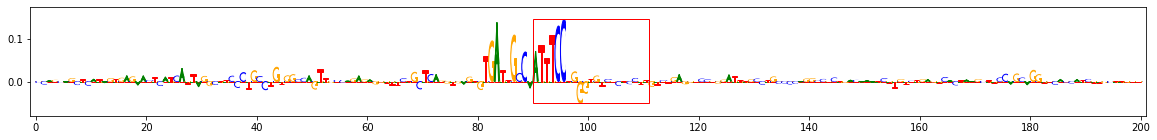

14821 511 0.9998350027443152 2.0545401006709594
slice(421, 621, None)


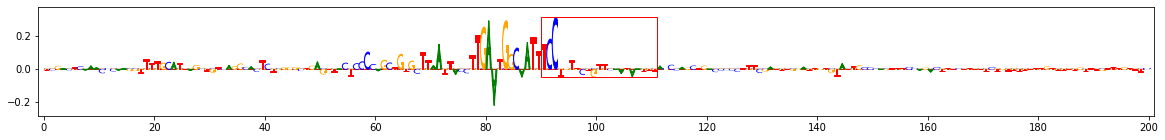

14938 506 0.992175593101461 2.282338182800522
slice(416, 616, None)


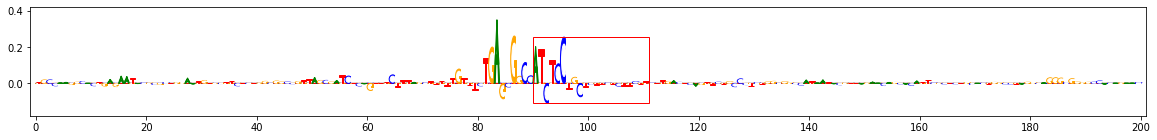

16328 508 0.9517222926966548 2.078842635165039
slice(418, 618, None)


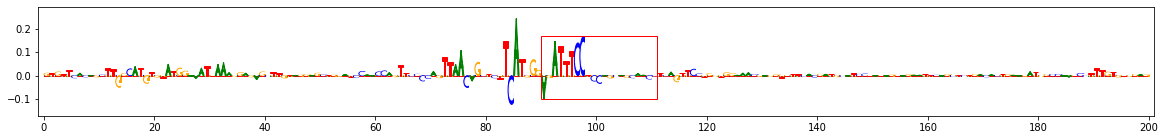

17355 509 0.9511785992744303 2.5528506544605674
slice(419, 619, None)


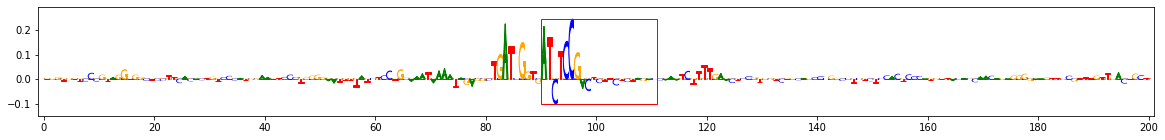

17484 513 0.9431800331649686 2.089384280913578
slice(423, 623, None)


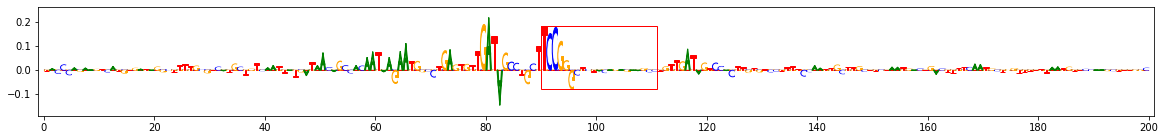

18600 500 0.9875089082644711 2.085136868262727
slice(410, 610, None)


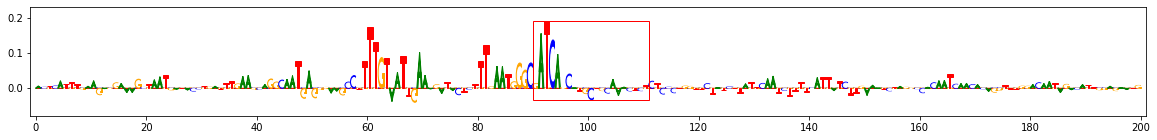

19434 502 0.9878466178319573 2.044802148260836
slice(412, 612, None)


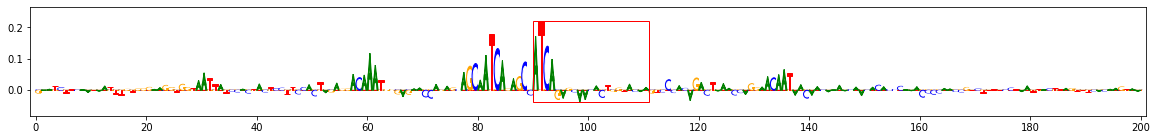

23984 501 0.9398398738576325 2.040013847474366
slice(411, 611, None)


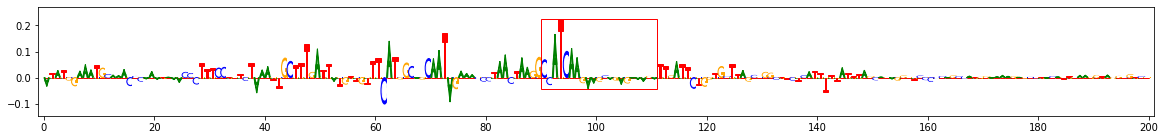

30290 505 0.9949998651304128 2.299304968657758
slice(415, 615, None)


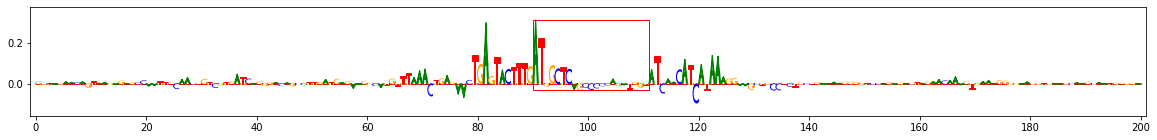

32973 510 0.957984758553913 2.0840814741056626
slice(420, 620, None)


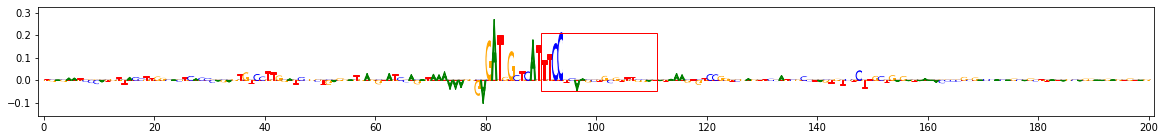

33075 509 0.9803109548225881 2.4001256137290876
slice(419, 619, None)


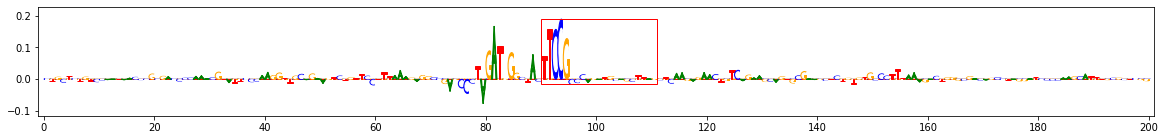

39024 515 0.9493969552732398 2.007897198015833
slice(425, 625, None)


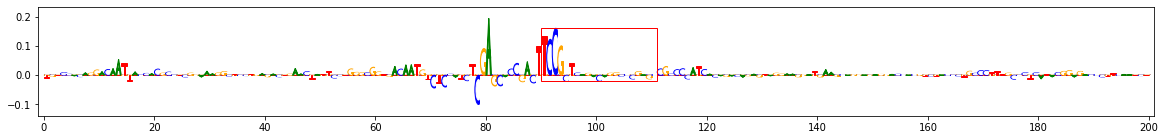

40774 505 0.9821409668392745 2.0736662391771277
slice(415, 615, None)


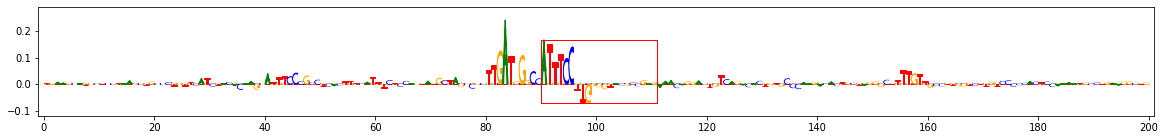

50269 379 0.9669067491389327 2.0222850805139307
slice(289, 489, None)


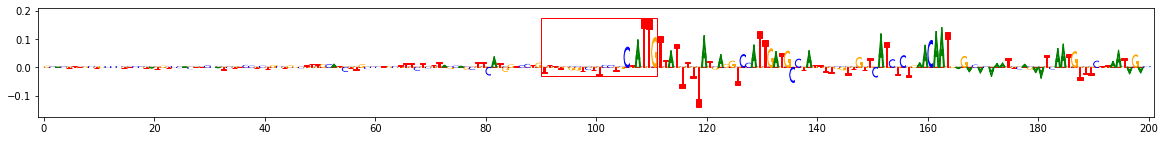

52313 548 0.9558610649240572 2.0168336137649656
slice(458, 658, None)


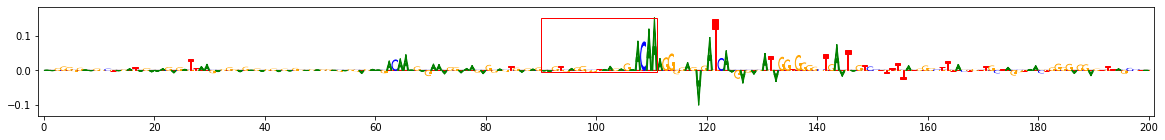

In [23]:
from modisco.visualization import viz_sequence

for seqidx, (posidx, _) in seq_to_best_example.items():
    print(seqidx, posidx,
          logperc_transformed_perseq_windowsum[seqidx, posidx],
          logperc_normal_perseq_windowsum[seqidx, posidx])
    center = posidx + int(window_size/2)
    leftflank = center - max(0,center-100)
    rightflank = min(1000,center+100) - center
    flank = min(leftflank, rightflank)                    
    the_slice = slice(center-leftflank, center+rightflank)
    print(the_slice)
    #viz_sequence.plot_weights( (transformed_perseq[seqidx][:,None]
    #                            *onehot_seq[seqidx])[the_slice], subticks_frequency=20)
    viz_sequence.plot_weights( nanog_profile_wn_contribs[seqidx][the_slice], subticks_frequency=20,
                               highlight={'red': [(flank-int(window_size/2), flank-int(window_size/2)+window_size)]})

50

In [119]:
rank_disagreements[0][:10]

array([ 401,  529,  529,  704, 1575, 2245, 2513, 2513, 2513, 2513])

In [120]:
rank_disagreements[1][:10]

array([772, 163, 181, 668, 782, 402, 210, 245, 250, 251])

In [99]:
transformed_perseq_windowsum[5,485]

14.128010830126641

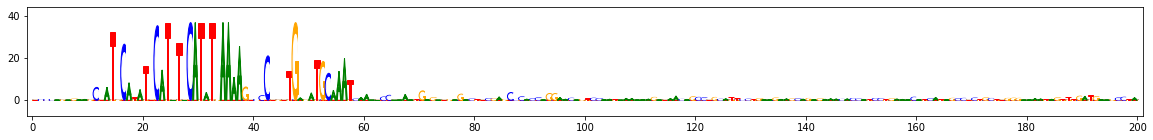

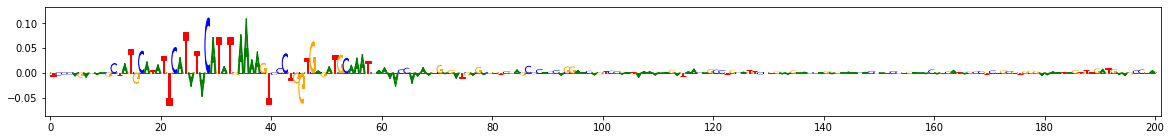

In [121]:
from modisco.visualization import viz_sequence

#sort indices by the sum of imp scores
indices_sorted_by_sumimp = np.argsort(np.sum(nanog_profile_wn_contribs, axis=(1,2)))

idx = 2245#indices_sorted_by_sumimp[-2000]
the_slice = slice(400,600)
viz_sequence.plot_weights( (transformed_perseq[idx][:,None]
                            *onehot_seq[idx])[the_slice], subticks_frequency=20)
viz_sequence.plot_weights( nanog_profile_wn_contribs[idx][the_slice], subticks_frequency=20 )

In [18]:
mad_dist = [scipy.stats.median_absolute_deviation(np.sum(x, axis=-1)) for x in nanog_profile_wn_contribs]

In [22]:
max_dist = [np.max(np.sum(x, axis=-1)) for x in nanog_profile_wn_contribs]

In [24]:
mad_dist_abs = [scipy.stats.median_absolute_deviation(np.abs(np.sum(x, axis=-1)) ) for x in nanog_profile_wn_contribs]
max_dist_abs = [np.max(np.abs(np.sum(x, axis=-1))) for x in nanog_profile_wn_contribs]

In [33]:
mad_dist_central = [scipy.stats.median_absolute_deviation(np.sum(x, axis=-1)[400:600])
                    for x in nanog_profile_wn_contribs]

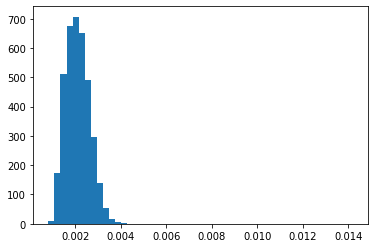

In [21]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.hist(mad_dist, bins=50, density=True)
plt.show()

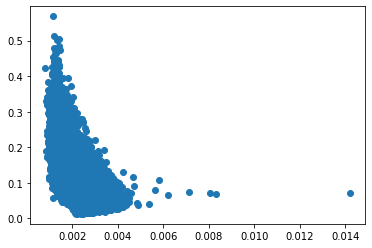

In [23]:
plt.scatter(mad_dist, max_dist)
plt.show()

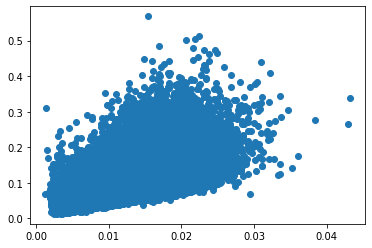

In [34]:
plt.scatter(mad_dist_central, max_dist)
plt.show()